# DMRG on single impurity spinless fermion model
The purpose is to test DMRG for different impurity model geometries and compare to the exact non-interacting solution.

In [1]:
using ITensors
using Plots
using LinearAlgebra

In [2]:
N     = 40    # Number of sites in chain
Npart = Int(N/2)   # Number of fermions  
sites = 1:N   # List of site numbers
s = siteinds("Fermion",N,conserve_qns=true);  # Indices for sites for spin-1/2 system

Useful functions:

In [12]:
function entanglement_entropy(ψ)
# Compute the von Neumann entanglement entropy across each bond of the MPS
    N = length(ψ)
    SvN = zeros(N)
    for b=1:N
        orthogonalize!(ψ, b)
        U,S,V = svd(ψ[b], (linkind(ψ, b-1), siteind(ψ, b)))
        for n=1:dim(S, 1)
            p = S[n,n]^2
            SvN[b] -= p * log(p)
        end
    end
    return SvN
end;

In [85]:
function band_diag(B,d)
# Band-diagonalize matrix B with a bandwidth of d:
    n = size(B,1); # Assumed to be square.
    U = Diagonal(ones(n,n));
    for k=1:Int(floor(n/d)-1)
      C = B[(k*d+1):n,((k-1)*d+1):(k*d)]; # Extract coupling matrix.
      F = qr(C); # Upper-triangularize.
      blocks = [[Diagonal(ones(k*d,k*d))]; [F.Q']]
      Q = cat(blocks...,dims=(1,2))    # Form full triangularizing unitary.    
      B = Q*B*Q'; # Apply to input matrix to transform for next step.
      U = Q*U; # Save this step's unitary to the full sequence.
    end
    return B; # Return the final band-diagonalized matrix.
end;

Define DMRG parameters

In [3]:
nsweeps = 30 # Make sure to use lots of sweeps, especially for excited states
maxdim = [200]
cutoff = [1E-8]
noise = [1E-6];

Setup a product configuration state with the correct total particle number which can be randomly permuted to construct the DMRG initial state:

In [5]:
state = ["Emp" for n in 1:N]
p = Npart
for i in N:-1:1
    if p >= i
      state[i] = "Occ"
      p -= 1
    end
end

## Star geometry

In [105]:
Γ = 0.1                           # total impurity-bath coupling strength
t = sqrt(Γ/(pi * (N-1)))          # hybridisation of impurity with each bath mode
ϵb = collect(range(-1, 1, length = (N-1))) # energy of bath modes
ϵi = 0;                           # energy of impurity mode

Create single-particle Hamiltonian matrix

In [121]:
Hstar = zeros(N,N);
Hstar[1,1] = ϵi;
for j=2:N
    Hstar[1,j] = t
    Hstar[j,1] = t
    Hstar[j,j] = ϵb[j-1]
end;

Construct Hamiltonian MPO for star geometry spinless fermion impurity model

In [8]:
ops = OpSum()
ops += ϵi,"n",1;
for j=2:N
    ops += t,"Cdag",1,"C",j
    ops += t,"Cdag",j,"C",1
    ops += ϵb[j-1],"n",j;
end
H = MPO(ops,s);

Compute the ground state ψ0

In [9]:
# Initialize wavefunction to be bond dimension 10 random MPS with number
# of particles the same as `state`
ψ0_init = randomMPS(s, state, 10)

# Check total number of particles:
@show flux(ψ0_init)

energy0,ψ0 = dmrg(H,ψ0_init; nsweeps, maxdim, cutoff, noise);

flux(ψ0_init) = QN("Nf",20,-1)
After sweep 1 energy=-10.06951413078146  maxlinkdim=22 maxerr=9.66E-09 time=69.603
After sweep 2 energy=-10.070377773506193  maxlinkdim=21 maxerr=9.95E-09 time=0.554
After sweep 3 energy=-10.07040959165669  maxlinkdim=13 maxerr=9.87E-09 time=0.441
After sweep 4 energy=-10.070409885743626  maxlinkdim=13 maxerr=9.79E-09 time=0.578
After sweep 5 energy=-10.070409888455792  maxlinkdim=12 maxerr=9.63E-09 time=0.902
After sweep 6 energy=-10.070409889049929  maxlinkdim=12 maxerr=9.83E-09 time=0.296
After sweep 7 energy=-10.070409889138405  maxlinkdim=12 maxerr=9.83E-09 time=0.294
After sweep 8 energy=-10.070409889153265  maxlinkdim=12 maxerr=9.83E-09 time=0.299
After sweep 9 energy=-10.070409889155973  maxlinkdim=12 maxerr=9.83E-09 time=0.318
After sweep 10 energy=-10.070409889156592  maxlinkdim=12 maxerr=9.83E-09 time=0.270
After sweep 11 energy=-10.070409889156725  maxlinkdim=12 maxerr=9.83E-09 time=0.303
After sweep 12 energy=-10.070409889156782  maxlinkdim=1

In [10]:
den = expect(ψ0,"n");

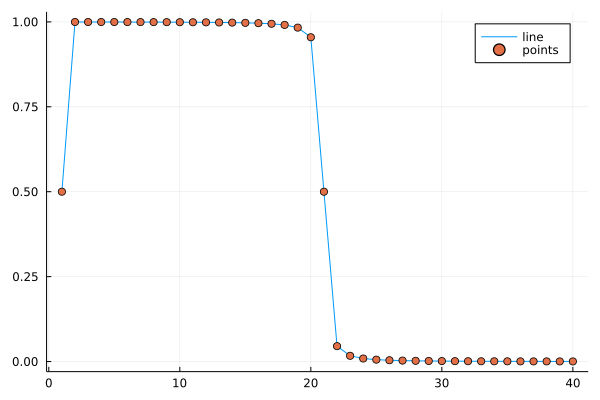

In [11]:
plot(sites, den, label="line")  
scatter!(sites, den, label="points") 

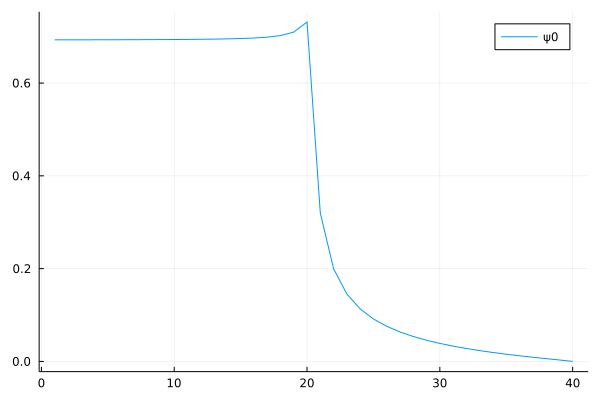

In [14]:
SvN = entanglement_entropy(ψ0);
plot(sites, SvN, label="ψ0") 

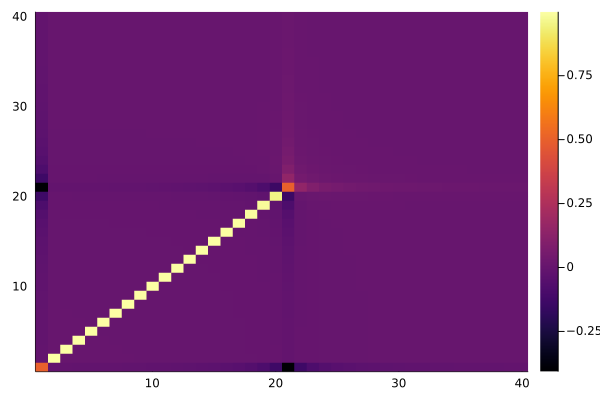

In [16]:
C = correlation_matrix(ψ0,"Cdag","C");
gr()
heatmap(sites, sites, C)

Reorder the bath orbitals so energies closer to the impurity are proximate.

In [110]:
ind = sortperm(abs.(ϵb)) # Broadcast abs() over vector using "." notation.
ϵb_ro = ϵb[ind]; # Sort the bath energies

In [102]:
ops = OpSum()
ops += ϵi,"n",1;
for j=2:N
    ops += t,"Cdag",1,"C",j
    ops += t,"Cdag",j,"C",1
    ops += ϵb_ro[j-1],"n",j;
end
H = MPO(ops,s);

In [103]:
# Initialize wavefunction to be bond dimension 10 random MPS with number
# of particles the same as `state`
ψ0_init = randomMPS(s, state, 10)

# Check total number of particles:
@show flux(ψ0_init)

energy0,ψ0 = dmrg(H,ψ0_init; nsweeps, maxdim, cutoff, noise);

flux(ψ0_init) = QN("Nf",20,-1)
After sweep 1 energy=-4.418242898810718  maxlinkdim=25 maxerr=9.96E-09 time=0.546
After sweep 2 energy=-5.683670800551902  maxlinkdim=24 maxerr=9.86E-09 time=1.100
After sweep 3 energy=-6.783323289709777  maxlinkdim=22 maxerr=9.78E-09 time=0.703
After sweep 4 energy=-7.778446827656232  maxlinkdim=14 maxerr=9.72E-09 time=0.606
After sweep 5 energy=-8.727240908353808  maxlinkdim=15 maxerr=9.64E-09 time=0.708
After sweep 6 energy=-9.470604713109209  maxlinkdim=18 maxerr=9.91E-09 time=0.486
After sweep 7 energy=-10.069958595934393  maxlinkdim=20 maxerr=9.82E-09 time=0.453
After sweep 8 energy=-10.070408657206912  maxlinkdim=17 maxerr=9.68E-09 time=0.807
After sweep 9 energy=-10.070409126865998  maxlinkdim=15 maxerr=1.00E-08 time=0.555
After sweep 10 energy=-10.070409128212294  maxlinkdim=15 maxerr=9.96E-09 time=0.510
After sweep 11 energy=-10.070409143227463  maxlinkdim=15 maxerr=9.96E-09 time=0.603
After sweep 12 energy=-10.07040914334197  maxlinkdim=15 maxe

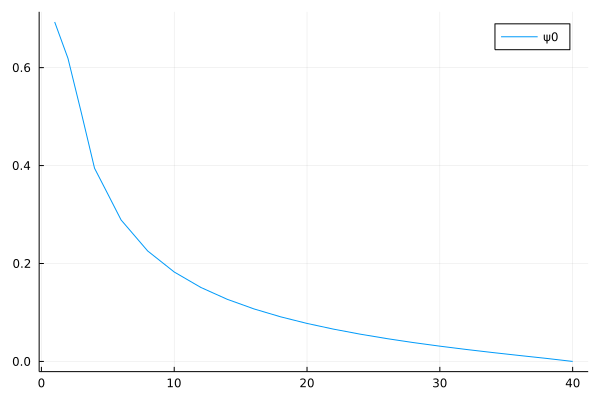

In [104]:
SvN = entanglement_entropy(ψ0);
plot(sites, SvN, label="ψ0") 

In [106]:
imp = 20
ops = OpSum()
ops += ϵi,"n",1;
b = 0
for j=1:N
    if j == imp
        ops += ϵi,"n",j;
    else
        b += 1
        ops += t,"Cdag",imp,"C",j 
        ops += t,"Cdag",j,"C",imp
        ops += ϵb[b],"n",j; 
    end    
end
H = MPO(ops,s);

In [107]:
# Initialize wavefunction to be bond dimension 10 random MPS with number
# of particles the same as `state`
ψ0_init = randomMPS(s, state, 10)

# Check total number of particles:
@show flux(ψ0_init)

energy0,ψ0 = dmrg(H,ψ0_init; nsweeps, maxdim, cutoff, noise);

flux(ψ0_init) = QN("Nf",20,-1)
After sweep 1 energy=-10.057030730649268  maxlinkdim=25 maxerr=9.78E-09 time=0.269
After sweep 2 energy=-10.070068103012947  maxlinkdim=30 maxerr=9.94E-09 time=0.282
After sweep 3 energy=-10.070384361615478  maxlinkdim=20 maxerr=9.82E-09 time=0.261
After sweep 4 energy=-10.070408045532643  maxlinkdim=15 maxerr=9.82E-09 time=0.235
After sweep 5 energy=-10.070409824925683  maxlinkdim=12 maxerr=9.57E-09 time=0.236
After sweep 6 energy=-10.070409858081668  maxlinkdim=12 maxerr=9.79E-09 time=0.279
After sweep 7 energy=-10.070409863997867  maxlinkdim=12 maxerr=9.01E-09 time=0.233
After sweep 8 energy=-10.070409864717409  maxlinkdim=12 maxerr=8.81E-09 time=0.232
After sweep 9 energy=-10.070409864859544  maxlinkdim=12 maxerr=8.81E-09 time=0.232
After sweep 10 energy=-10.070409864889466  maxlinkdim=12 maxerr=8.81E-09 time=0.257
After sweep 11 energy=-10.070409864895709  maxlinkdim=12 maxerr=8.81E-09 time=0.326
After sweep 12 energy=-10.070409864896899  maxlinkdim=

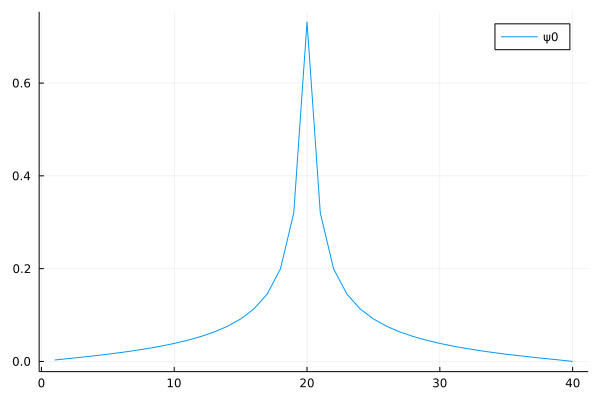

In [108]:
SvN = entanglement_entropy(ψ0);
plot(sites, SvN, label="ψ0") 

Exact result

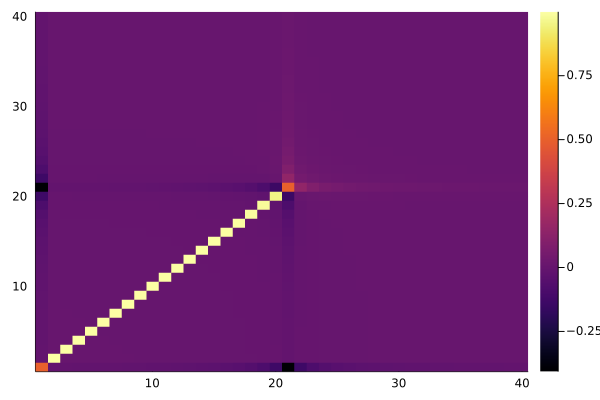

In [88]:
F = eigen(Hstar); 
ind = sortperm(F.values)
en = F.values[ind]
vecs = F.vectors[:,ind];
en_gs = sum(en[1:Npart]); # Ground state energy for Npart fermions.
rho = vecs[:,1:Npart]*(vecs[:,1:Npart]'); 
heatmap(sites, sites, rho)

In [22]:
en_gs

-10.070409974885262

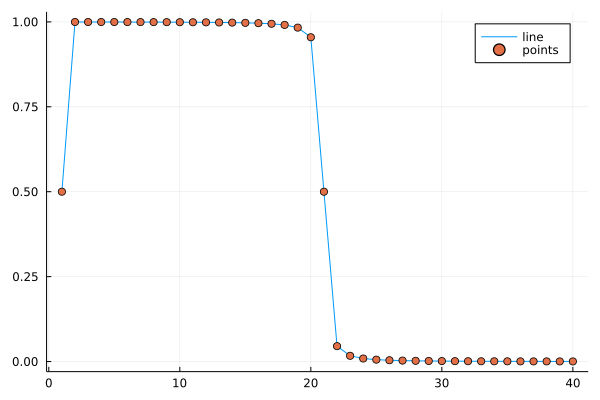

In [23]:
plot(sites, diag(rho), label="line")  
scatter!(sites, diag(rho), label="points") 

In [120]:
Hstar = zeros(N,N);
Hstar[1,1] = ϵi;
for j=2:N
    Hstar[1,j] = t
    Hstar[j,1] = t
    Hstar[j,j] = ϵb_ro[j-1]
end;

In [122]:
Hchain = band_diag(Hstar,1)

40×40 Matrix{Float64}:
  0.0          -0.178412     -2.82055e-17  …   3.78058e-20   1.30484e-20
 -0.178412      7.28584e-17  -0.592349         5.72594e-18   6.88754e-18
 -2.82055e-17  -0.592349     -1.11022e-16      1.83758e-17  -1.01751e-17
 -9.68927e-18  -7.8015e-18   -0.52929         -2.50695e-17   2.31463e-17
  2.5484e-17   -3.44514e-17   2.52199e-17     -1.62541e-17   1.23519e-17
  2.7568e-17   -3.10436e-17  -3.40257e-18  …  -8.10204e-17  -6.12483e-17
  2.44364e-17   2.38815e-18  -1.52024e-17      3.73565e-17  -7.78758e-17
 -2.54843e-17   2.92297e-17   1.16313e-17      5.39554e-17   1.39511e-16
 -2.37144e-17  -1.47175e-18   3.04893e-17     -8.18346e-19  -1.11869e-16
 -1.77514e-17   1.015e-17     6.42519e-18      3.08785e-17   1.47605e-17
  1.46683e-17   3.77057e-17  -1.68902e-17  …  -8.58456e-17  -4.69773e-17
  1.21151e-17   2.0982e-17    2.23468e-17     -9.72879e-17   4.68352e-17
 -8.53949e-18  -3.72449e-17  -7.56069e-18     -6.9385e-17   -1.19062e-16
  ⋮                         

In [119]:
Hchain = band_diag(Hstar,1)

40×40 Matrix{Float64}:
  0.0          -0.178412     -8.31449e-19  …  -1.27073e-18  -2.99305e-17
 -0.178412      0.0          -0.592349         2.77619e-17   6.47607e-17
 -8.31449e-19  -0.592349      1.38778e-17     -7.44297e-18   9.07299e-18
 -2.48821e-17  -1.9316e-17    0.52929         -6.34076e-18  -6.91825e-17
  5.68487e-19  -1.15832e-17   5.63743e-18     -6.11093e-17   8.79115e-18
 -3.38608e-18  -1.90838e-17  -2.84237e-17  …   5.65625e-17   1.3209e-17
  8.97924e-19  -1.89231e-17  -1.45369e-17     -2.10062e-17   5.1458e-17
 -7.40931e-18  -2.11462e-17   4.11547e-17     -4.1891e-17   -6.65787e-17
  5.76903e-19   7.50752e-18   1.24524e-17      6.98802e-17  -8.43149e-17
  1.2127e-17    2.92694e-17   3.00855e-17      2.015e-18     1.8856e-17
  2.36364e-19  -2.52478e-17   2.80253e-18  …  -8.69271e-17   5.21451e-17
  1.18071e-17   1.13569e-17  -1.3098e-17      -7.31524e-17   5.15866e-17
 -6.79652e-19   2.66281e-17   8.21393e-18      1.2538e-18   -2.51739e-17
  ⋮                            

In [113]:
ops = OpSum()
for j=1:(N-1)
    ops += Hchain[j,j+1],"Cdag",j,"C",j+1
    ops += Hchain[j+1,j],"Cdag",j+1,"C",j
    ops += Hchain[j,j],"n",j;
end
ops += Hchain[N,N],"n",N;
H = MPO(ops,s);

In [114]:
# Initialize wavefunction to be bond dimension 10 random MPS with number
# of particles the same as `state`
ψ0_init = randomMPS(s, state, 10)

# Check total number of particles:
@show flux(ψ0_init)

energy0,ψ0 = dmrg(H,ψ0_init; nsweeps, maxdim, cutoff, noise);

flux(ψ0_init) = QN("Nf",20,-1)
After sweep 1 energy=-6.559949000303385  maxlinkdim=26 maxerr=9.45E-09 time=0.619
After sweep 2 energy=-8.005773068567777  maxlinkdim=47 maxerr=9.87E-09 time=0.762
After sweep 3 energy=-8.944590899015513  maxlinkdim=60 maxerr=9.90E-09 time=1.039
After sweep 4 energy=-9.532592482281954  maxlinkdim=59 maxerr=9.89E-09 time=1.261
After sweep 5 energy=-9.855648735992489  maxlinkdim=52 maxerr=9.82E-09 time=1.344
After sweep 6 energy=-10.001849259343102  maxlinkdim=51 maxerr=1.00E-08 time=0.970
After sweep 7 energy=-10.057761196434589  maxlinkdim=48 maxerr=9.99E-09 time=1.912
After sweep 8 energy=-10.069517490404435  maxlinkdim=49 maxerr=9.99E-09 time=2.151
After sweep 9 energy=-10.070408038281668  maxlinkdim=47 maxerr=9.93E-09 time=1.375
After sweep 10 energy=-10.070409423178317  maxlinkdim=46 maxerr=9.99E-09 time=1.173
After sweep 11 energy=-10.07040941664322  maxlinkdim=46 maxerr=9.89E-09 time=1.008
After sweep 12 energy=-10.070409423227781  maxlinkdim=46 max

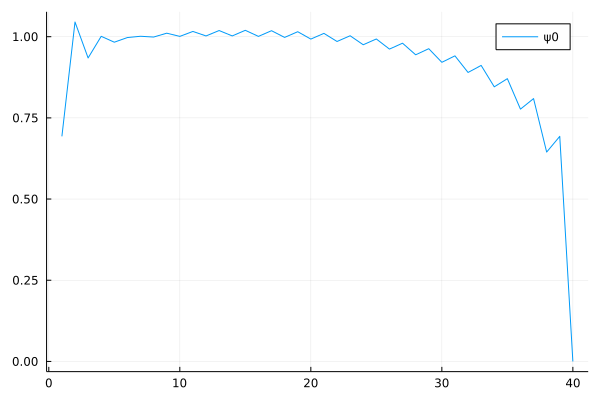

In [115]:
SvN = entanglement_entropy(ψ0);
plot(sites, SvN, label="ψ0") 

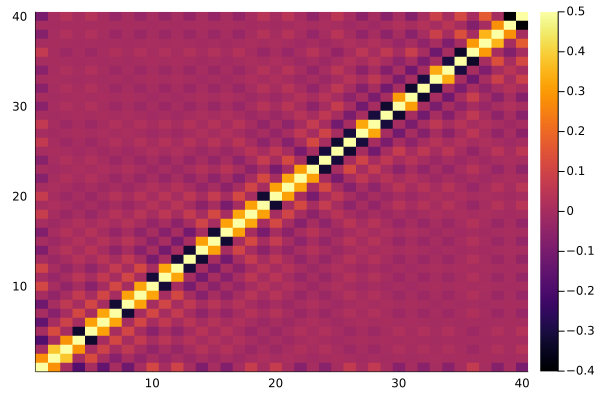

In [41]:
C = correlation_matrix(ψ0,"Cdag","C");
gr()
heatmap(sites, sites, C)

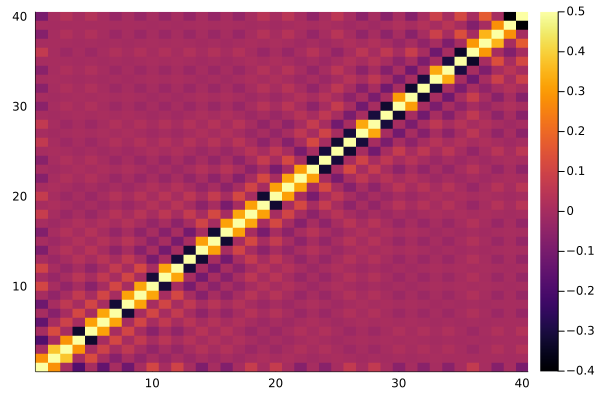

In [42]:
heatmap(sites, sites, F.Q'*rho*F.Q)

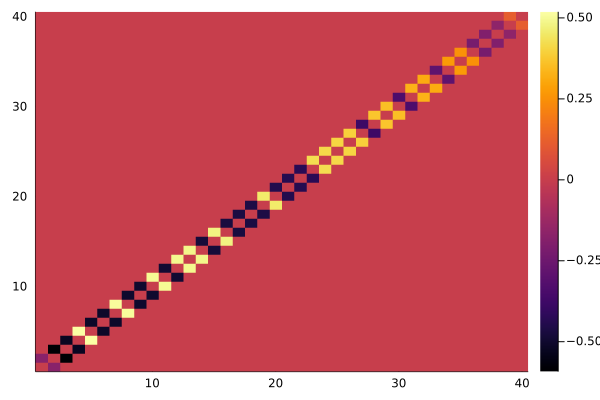

In [84]:
Hbd = band_diag(Hmat,1);
heatmap(sites, sites, Hbd)